<a href="https://colab.research.google.com/github/kjprice/smu-capstone/blob/master/notebooks/ASL_Signs_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os, shutil, copy, ntpath, datetime, zipfile
import keras
from keras import models, layers, callbacks
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import tensorflow as tf
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import boto3
import glob
import ntpath
import re

import numpy as np
import pandas as pd

Using TensorFlow backend.


## Make sure we have GPU

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


#### Settings

In [0]:
IMAGE_SHAPE=(150, 150, 3)

LIMIT_BATCHES = 593
#LIMIT_BATCHES = None

NUM_EPOCHS = 10
BATCH_SIZE = 20
NUM_CLASSES = 29

# PRETRAIN_MODEL = 'conv_base_local'
PRETRAIN_MODEL = 'conv_base_vgg16'
# PRETRAIN_MODEL = None

TEST_TRAIN_SPLIT = .95 # Train Size

#### Set Folders

In [0]:
#### FilePath Information
DATA_DIR = '/content/gdrive/My Drive/SMU/Capstone/DataSets/'
ASL_ALPHABET_DATASET_ZIP = os.path.join(DATA_DIR, 'asl_alphabet.zip')
LOCAL_DATASET_ZIP = '/tmp/asl_alphabet.zip'

LOCAL_DATASET_DIR = '/tmp/asl_alphabet'

TRAIN_DATASET_NAME = 'processed_asl_train'
LOCAL_TRAIN_DIR = os.path.join(LOCAL_DATASET_DIR, TRAIN_DATASET_NAME)

#NEW_TRAIN_DIR = '/tmp/asl_alphabet_train'
#NEW_TEST_DIR = '/tmp/asl_alphabet_test'

#FABRICATED_DIRS = [
#    NEW_TRAIN_DIR,
#    NEW_TEST_DIR
#]

SAVED_MODEL_DIR = os.path.join(DATA_DIR, 'models/asl_alphabet')

#### Download Data

In [0]:
if not os.path.isfile(LOCAL_DATASET_ZIP):
  %time shutil.copy(ASL_ALPHABET_DATASET_ZIP, LOCAL_DATASET_ZIP)


#### Extract Data

In [0]:
if not os.path.isdir(LOCAL_DATASET_DIR):
  with zipfile.ZipFile(LOCAL_DATASET_ZIP, 'r') as zip_ref:
      %time zip_ref.extractall('/tmp')

In [8]:
temp_zip_folder = '/tmp/data/fabricated/asl_alphabet'
if not os.path.isdir('/tmp/data/fabricated/asl_alphabet'):
  print('not sure where the zip folder exported the directory but it is not where we expected')
else:
  shutil.move('/tmp/data/fabricated/asl_alphabet', LOCAL_DATASET_DIR)

not sure where the zip folder exported the directory but it is not where we expected


In [9]:
AVAILABLE_DATASETS = os.listdir(LOCAL_DATASET_DIR)
print(AVAILABLE_DATASETS)

['processed_ahe_inverted_asl_test', 'processed_ahe_asl_test', 'processed_asl_train', 'processed_rgb_ahe_test', 'processed_inverted_rgb_ahe_test', 'processed_original_test', 'processed_grayscale_test']


In [10]:
if not TRAIN_DATASET_NAME in AVAILABLE_DATASETS:
  raise Exception('we are expecting to see {} as one of the available datasets'.format(TRAIN_DATASET_NAME))
TEST_DATASET_NAMES = [dataset for dataset in AVAILABLE_DATASETS if dataset != TRAIN_DATASET_NAME]
print('We have one training set and {} test sets'.format(len(TEST_DATASET_NAMES)))
LOCAL_TEST_DIRS = [os.path.join(LOCAL_DATASET_DIR, name) for name in TEST_DATASET_NAMES]

We have one training set and 6 test sets


#### Create Split training/test data

In [0]:
def get_sign_folders(from_folder):
  # https://stackoverflow.com/questions/973473/getting-a-list-of-all-subdirectories-in-the-current-directory
  folders = next(os.walk(from_folder))[1]
  return folders

In [0]:
# A, B, C, D, DELETE, etc
ASL_FOLDERS = get_sign_folders(LOCAL_TRAIN_DIR)

#### Create Data Generators

In [0]:
def create_test_datagen(directory):
  test_datagen = ImageDataGenerator(rescale=1./255)
  return test_datagen.flow_from_directory(
         directory,
         target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
         batch_size = BATCH_SIZE,
         color_mode = "rgb",
         class_mode='categorical'
  )

In [0]:
# dataset definition with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    )

In [15]:
#create generators
train_generator = train_datagen.flow_from_directory(
           LOCAL_TRAIN_DIR,
           target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
           batch_size=BATCH_SIZE,
           class_mode = 'categorical',
           subset='training'
)

#create generators
validation_generator = train_datagen.flow_from_directory(
           LOCAL_TRAIN_DIR,
           target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
           batch_size=BATCH_SIZE,
           class_mode = 'categorical',
           subset='validation'
)

test_generators = [create_test_datagen(dir) for dir in LOCAL_TEST_DIRS]

Found 446310 images belonging to 29 classes.
Found 49590 images belonging to 29 classes.
Found 4350 images belonging to 29 classes.
Found 4350 images belonging to 29 classes.
Found 4350 images belonging to 29 classes.
Found 4350 images belonging to 29 classes.
Found 4350 images belonging to 29 classes.
Found 4350 images belonging to 29 classes.


# Models

In [0]:
def create_vgg_model():
    conv_base = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))
    print(conv_base.summary())
    
    conv_base.trainable = False
    
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(29, activation='sigmoid'))

    optimizer = keras.optimizers.RMSprop(lr=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    return model
    
    

In [0]:
def create_blank_model():
    model = models.Sequential()
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=IMAGE_SHAPE))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))

    #Add a classfier on top of the convnet
    model.add(layers.Flatten())
    model.add(layers.Dropout(.5))
    model.add(layers.Dense(128, activation='relu'))
    #model.add(layers.BatchNormalization())
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    #compile the model
    optimizer = keras.optimizers.RMSprop(lr=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    print(model.summary())
    return model


In [18]:
if not PRETRAIN_MODEL:
    model = create_blank_model()
elif PRETRAIN_MODEL == 'conv_base_vgg16':
    model = create_vgg_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [19]:
steps_per_epoch = None

if LIMIT_BATCHES is None:
  steps_per_epoch_train = len(train_generator)
  steps_per_epoch_val = len(validation_generator)
  steps_per_epoch_test = len(test_generators[0])
else:
  steps_per_epoch_train = LIMIT_BATCHES
  steps_per_epoch_val = (LIMIT_BATCHES / len(train_generator)) * len(validation_generator)
  steps_per_epoch_test = (LIMIT_BATCHES / len(train_generator)) * len(test_generators[0])

print('total batches {}'.format(len(train_generator)))
print('steps_per_epoch_train {}'.format(steps_per_epoch_train))
print('steps_per_epoch_test {}'.format(steps_per_epoch_test))
print('steps_per_epoch_val {}'.format(steps_per_epoch_val))


total batches 22316
steps_per_epoch_train 593
steps_per_epoch_test 5.792884029395949
steps_per_epoch_val 65.90069905000897


In [20]:

history= model.fit_generator (
train_generator,
epochs = NUM_EPOCHS,
steps_per_epoch=steps_per_epoch_train,
validation_steps=steps_per_epoch_val,
#callbacks = callbacks_list,
validation_data=validation_generator,
verbose=1 \
)

Epoch 1/10
593/593 [==============================] - 119s 200ms/step - loss: 2.5929 - acc: 0.3180 - val_loss: 2.2668 - val_acc: 0.3970
Epoch 2/10
593/593 [==============================] - 115s 194ms/step - loss: 1.6393 - acc: 0.5618 - val_loss: 1.7861 - val_acc: 0.4962
Epoch 3/10
593/593 [==============================] - 115s 193ms/step - loss: 1.3168 - acc: 0.6379 - val_loss: 1.5532 - val_acc: 0.5432
Epoch 4/10
593/593 [==============================] - 115s 193ms/step - loss: 1.1165 - acc: 0.6798 - val_loss: 1.3981 - val_acc: 0.5894
Epoch 5/10
593/593 [==============================] - 115s 193ms/step - loss: 1.0077 - acc: 0.7099 - val_loss: 1.3171 - val_acc: 0.6227
Epoch 6/10
593/593 [==============================] - 115s 193ms/step - loss: 0.9396 - acc: 0.7262 - val_loss: 1.2453 - val_acc: 0.6394
Epoch 7/10
593/593 [==============================] - 115s 193ms/step - loss: 0.8619 - acc: 0.7441 - val_loss: 1.1336 - val_acc: 0.6598
Epoch 8/10
593/593 [============================

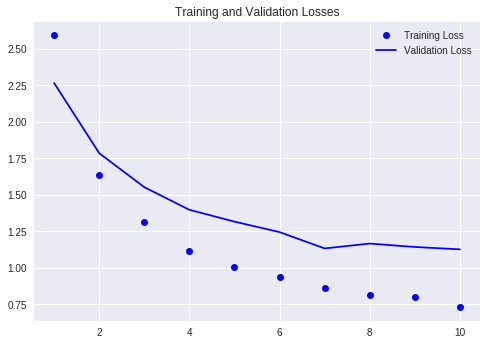

In [21]:
#visualization of model performance
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values =  history_dict['val_loss']
acc_values = history_dict['acc']

epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
plt.plot(epochs,val_loss_values, 'b', label = 'Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel='Epochs'
plt.ylabel='Loss'
plt.legend()
plt.show()

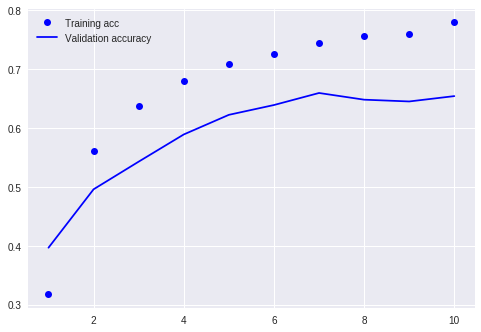

In [22]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs,val_acc_values, 'b', label='Validation accuracy')
plt.xlabel = 'Epochs'
plt.ylabel = 'Loss'
plt.legend()

plt.show()

## Validate against each of the test generators

In [23]:
for generator, _dir in zip(test_generators, LOCAL_TEST_DIRS):
  test_loss, test_acc = model.evaluate_generator(generator, steps=steps_per_epoch_test)
  print('{}: {}'.format(_dir, test_acc))

/tmp/asl_alphabet/processed_ahe_inverted_asl_test: 0.8333333233992258
/tmp/asl_alphabet/processed_ahe_asl_test: 0.8583333492279053
/tmp/asl_alphabet/processed_rgb_ahe_test: 0.850000003973643
/tmp/asl_alphabet/processed_inverted_rgb_ahe_test: 0.825000007947286
/tmp/asl_alphabet/processed_original_test: 0.9166666567325592
/tmp/asl_alphabet/processed_grayscale_test: 0.75
